In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd
from itertools import product

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
from scipy.stats.distributions import chi2 as chi2_dist

c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
#path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper', 'ULTIMA COSA', 'PG')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [2]:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


First, let's fix some parameters

In [3]:
#Fix params
#L_bar = 0.90
beta = 1

num_free_parameters = 3
#dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) - num_free_parameters
dof_CC = len(ds_CC[0]) - 2 #num_free_parameters
dof_PPS = ds_SN_plus_shoes[2].shape[0] - num_free_parameters

confidence_level = 0.683 #1 sigma contour
#confidence_level = 0.954 #2 sigma contour
#confidence_level = 0.997 #3 sigma contour


In [4]:
from scipy.stats import chi2

def chi2_threshold(N, p, confidence):
    """
    Compute the chi-square threshold for model rejection based on a given confidence level.
    
    Parameters:
    N (int): Number of data points
    p (int): Number of parameters
    confidence (float): Confidence level (e.g., 0.95 for 95%)
    
    Returns:
    float: Reduced chi-square threshold
    """
    nu = N - p  # Degrees of freedom
    chi2_crit = chi2.ppf(confidence, df=nu)  # Critical chi-square value
    return chi2_crit / nu  # Convert to reduced chi-square

# Example usage
#N = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) #PPS+CC
N_CC = len(ds_CC[0]) #CC
N_PPS = ds_SN_plus_shoes[2].shape[0] #PPS
p = 3
confidence_level = 0.683  # 68.3% confidence threshold

print('CC')
chi2_th_CC = chi2_threshold(N_CC, 2, confidence_level)
print(f"Reduced chi-square threshold for {confidence_level*100}% confidence: {chi2_th_CC:.5f}")
print(1+np.sqrt(2/(N_CC-2)))

print('PPS')
chi2_th_PPS = chi2_threshold(N_PPS, 3, confidence_level)
print(f"Reduced chi-square threshold for {confidence_level*100}% confidence: {chi2_th_PPS:.5f}")
print(1+np.sqrt(2/(N_PPS-3)))


CC
Reduced chi-square threshold for 68.30000000000001% confidence: 1.10721
1.2672612419124243
PPS
Reduced chi-square threshold for 68.30000000000001% confidence: 1.01624
1.034773407121036


# PG model analysis

In [5]:
#PG MODEL
#r_min = 1
#s_min = 2

model = 'BETA'
H0_values = np.linspace(60,80,20)[::-1] 
L_bar_values = np.logspace(-1,1,20)
Mabs_values = np.linspace(-21,-18.5,20)
print(H0_values, L_bar_values, Mabs_values)

#r = 1; s = 2 
r = 1; s = 3 
#r = 1; s = 4 

matrix_gila_chi2_CC = np.load(os.path.join(path_data, 'matrix_chi2_{0}_r={1}_s={2}_PG_CC.npy'.format(model, r, s)))
matrix_gila_aou_CC = np.load(os.path.join(path_data, 'matrix_aou_{0}_r={1}_s={2}_PG_CC.npy'.format(model, r, s)))

matrix_gila_chi2_PPS = np.load(os.path.join(path_data, 'matrix_chi2_{0}_r={1}_s={2}_PG_PPS.npy'.format(model, r, s)))
matrix_gila_aou_PPS = np.load(os.path.join(path_data, 'matrix_aou_{0}_r={1}_s={2}_PG_PPS.npy'.format(model, r, s)))

[80.         78.94736842 77.89473684 76.84210526 75.78947368 74.73684211
 73.68421053 72.63157895 71.57894737 70.52631579 69.47368421 68.42105263
 67.36842105 66.31578947 65.26315789 64.21052632 63.15789474 62.10526316
 61.05263158 60.        ] [ 0.1         0.1274275   0.16237767  0.20691381  0.26366509  0.33598183
  0.42813324  0.54555948  0.6951928   0.88586679  1.12883789  1.43844989
  1.83298071  2.33572147  2.97635144  3.79269019  4.83293024  6.15848211
  7.8475997  10.        ] [-21.         -20.86842105 -20.73684211 -20.60526316 -20.47368421
 -20.34210526 -20.21052632 -20.07894737 -19.94736842 -19.81578947
 -19.68421053 -19.55263158 -19.42105263 -19.28947368 -19.15789474
 -19.02631579 -18.89473684 -18.76315789 -18.63157895 -18.5       ]


In [6]:
#print(matrix_gila_chi2_CC)
print(dof_CC)

28


### Important questions

In [7]:
#aou_threshold = 13.2
aou_threshold = 12.7

print('CC')
masked_data_with_aou_CC = np.where(matrix_gila_aou_CC >= aou_threshold, matrix_gila_chi2_CC, np.nan)
print('Has integration issues?: {}'.format(np.all(np.isnan(matrix_gila_chi2_CC)))) #should be False
print('Has issues when Aou cut-off is applied?: {}'.format(np.all(np.isnan(masked_data_with_aou_CC))))#should be False
print('chi2_min<=chi2_threshold?: {}'.format(np.nanmin(masked_data_with_aou_CC)/dof_CC<=chi2_th_CC))#should be True

print('\n')

print('PPS')
masked_data_with_aou_PPS = np.where(matrix_gila_aou_PPS >= aou_threshold, matrix_gila_chi2_PPS, np.nan)
print('Has integration issues?: {}'.format(np.all(np.isnan(matrix_gila_chi2_PPS)))) #should be False
print('Has issues when Aou cut-off is applied?: {}'.format(np.all(np.isnan(masked_data_with_aou_PPS))))#should be False
print('chi2_min<=chi2_threshold?: {}'.format(np.nanmin(masked_data_with_aou_PPS)/dof_PPS<=chi2_th_PPS))#should be True


CC
Has integration issues?: False
Has issues when Aou cut-off is applied?: False
chi2_min<=chi2_threshold?: True


PPS
Has integration issues?: False
Has issues when Aou cut-off is applied?: False
chi2_min<=chi2_threshold?: True


In [8]:
print('CC')
print(r'Minimum of the reduced $\chi^2$:{}'.format(np.nanmin(masked_data_with_aou_CC)/dof_CC))
print(r'Minimum of the reduced $\chi^2$:{}'.format(masked_data_with_aou_CC[10,0,2]/dof_CC))
#Double check
where_global_min = np.where(masked_data_with_aou_CC==np.nanmin(masked_data_with_aou_CC))
print(where_global_min)

print(H0_values[where_global_min[0][0]], L_bar_values[where_global_min[1][0]], Mabs_values[where_global_min[2][0]])


print('PPS')
print(r'Minimum of the reduced $\chi^2$:{}'.format(np.nanmin(masked_data_with_aou_PPS)/dof_PPS))
#Double check
where_global_min = np.where(masked_data_with_aou_PPS==np.nanmin(masked_data_with_aou_PPS))
masked_data_with_aou_PPS[where_global_min]/dof_PPS

CC
Minimum of the reduced $\chi^2$:0.5418811346210938
Minimum of the reduced $\chi^2$:2.08150931127797
(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10]), array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]))
69.47368421052632 0.8858667904100825 -21.0
PPS
Minimum of the reduced $\chi^2$:0.8877725374909906


array([0.88777254])

In [9]:
print('CC')
masked_data_with_aou_CC = np.where(matrix_gila_aou_CC >= aou_threshold, matrix_gila_chi2_CC, np.nan)
masked_data_with_1_sigma = np.where(matrix_gila_chi2_CC/dof_CC <= chi2_th_CC, matrix_gila_chi2_CC, np.nan)
masked_data_with_aou_1_sigma = np.where(matrix_gila_chi2_CC/dof_CC <= chi2_th_CC, masked_data_with_aou_CC, np.nan)
print(masked_data_with_aou_CC)
print(masked_data_with_1_sigma)
print(masked_data_with_aou_1_sigma)

print('PPS')
masked_data_with_aou_PPS = np.where(matrix_gila_aou_PPS >= aou_threshold, matrix_gila_chi2_PPS, np.nan)
masked_data_with_1_sigma = np.where(matrix_gila_chi2_PPS/dof_PPS <= chi2_th_PPS, matrix_gila_chi2_PPS, np.nan)
masked_data_with_aou_1_sigma = np.where(matrix_gila_chi2_PPS/dof_PPS <= chi2_th_PPS, masked_data_with_aou_PPS, np.nan)
print(masked_data_with_aou_PPS)
print(masked_data_with_1_sigma)
print(masked_data_with_aou_1_sigma)

CC
[[[160.46745907 160.46745907 160.46745907 ... 160.46745907 160.46745907
   160.46745907]
  [ 60.77067623  60.77067623  60.77067623 ...  60.77067623  60.77067623
    60.77067623]
  [ 50.26672569  50.26672569  50.26672569 ...  50.26672569  50.26672569
    50.26672569]
  ...
  [         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]]

 [[147.22140295 147.22140295 147.22140295 ... 147.22140295 147.22140295
   147.22140295]
  [ 54.66980595  54.66980595  54.66980595 ...  54.66980595  54.66980595
    54.66980595]
  [ 47.44623945  47.44623945  47.44623945 ...  47.44623945  47.44623945
    47.44623945]
  ...
  [         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]
  [ 

# 3D Monte Carlo sampling

[[[9.13056528e-06 9.13056528e-06 9.13056528e-06 ... 9.13056528e-06
   9.13056528e-06 9.13056528e-06]
  [2.43967229e-04 2.43967229e-04 2.43967229e-04 ... 2.43967229e-04
   2.43967229e-04 2.43967229e-04]
  [3.44874622e-04 3.44874622e-04 3.44874622e-04 ... 3.44874622e-04
   3.44874622e-04 3.44874622e-04]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[1.41277076e-05 1.41277076e-05 1.41277076e-05 ... 1.41277076e-05
   1.41277076e-05 1.41277076e-05]
  [2.98294692e-04 2.98294692e-04 2.98294692e-04 ... 2.98294692e-04
   2.98294692e-04 2.98294692e-04]
  [3.78466363e-04 3.78466363e-04 3.78466363e-04 ... 3.78466363e-04
   3.78466363e-04 3.78466363e-04]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000

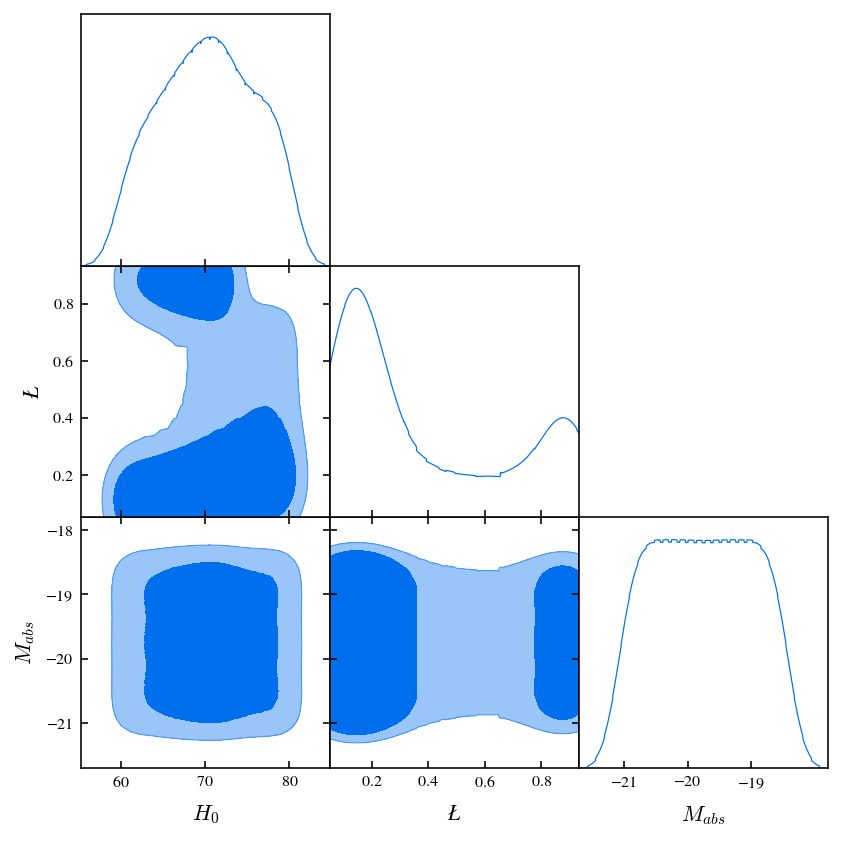

In [16]:
import getdist
import getdist.plots as gdplt
%matplotlib inline

x_vals = H0_values 
y_vals = L_bar_values 
z_vals = Mabs_values

aux = masked_data_with_aou_CC.copy()/np.nanmin(masked_data_with_aou_CC)
aux[np.isnan(masked_data_with_aou_CC)] = np.inf

p3d = np.exp(-aux/2)

# Normalize the distribution
p3d /= np.sum(p3d)
print(p3d)
print(p3d.shape)
# Convert 3D posterior into samples
flattened_probs = p3d.flatten()
grid_points = np.array(np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')).reshape(3, -1).T

# Sample points from the distribution
num_samples = int(1e7)  # Number of samples you want
sample_indices = np.random.choice(len(flattened_probs), size=num_samples, p=flattened_probs)
samples = grid_points[sample_indices]
samples_CC = samples.copy()

# Convert to GetDist format
gd_samples = getdist.mcsamples.MCSamples(samples=samples, names=['x', 'y', 'z'],
                                         labels=[r'H_0', r'\L', r'M_{abs}'],
                                         settings={'mult_bias_correction_order':0,
                                                   'smooth_scale_2D':0.3,
                                                   'smooth_scale_1D':0.3}
                                         )

# Plot using GetDist
g = gdplt.get_subplot_plotter()
g.triangle_plot([gd_samples], filled=True)
g.export(path_data+'triangle_gila_plot_CC_{0}_r={1}_s={2}.pdf'.format(model, r, s))
plt.show()

15.172671769390625
58.28226071578317
1.0
3.841265506933453
0.0010962711856075493
0.0002648164953018352


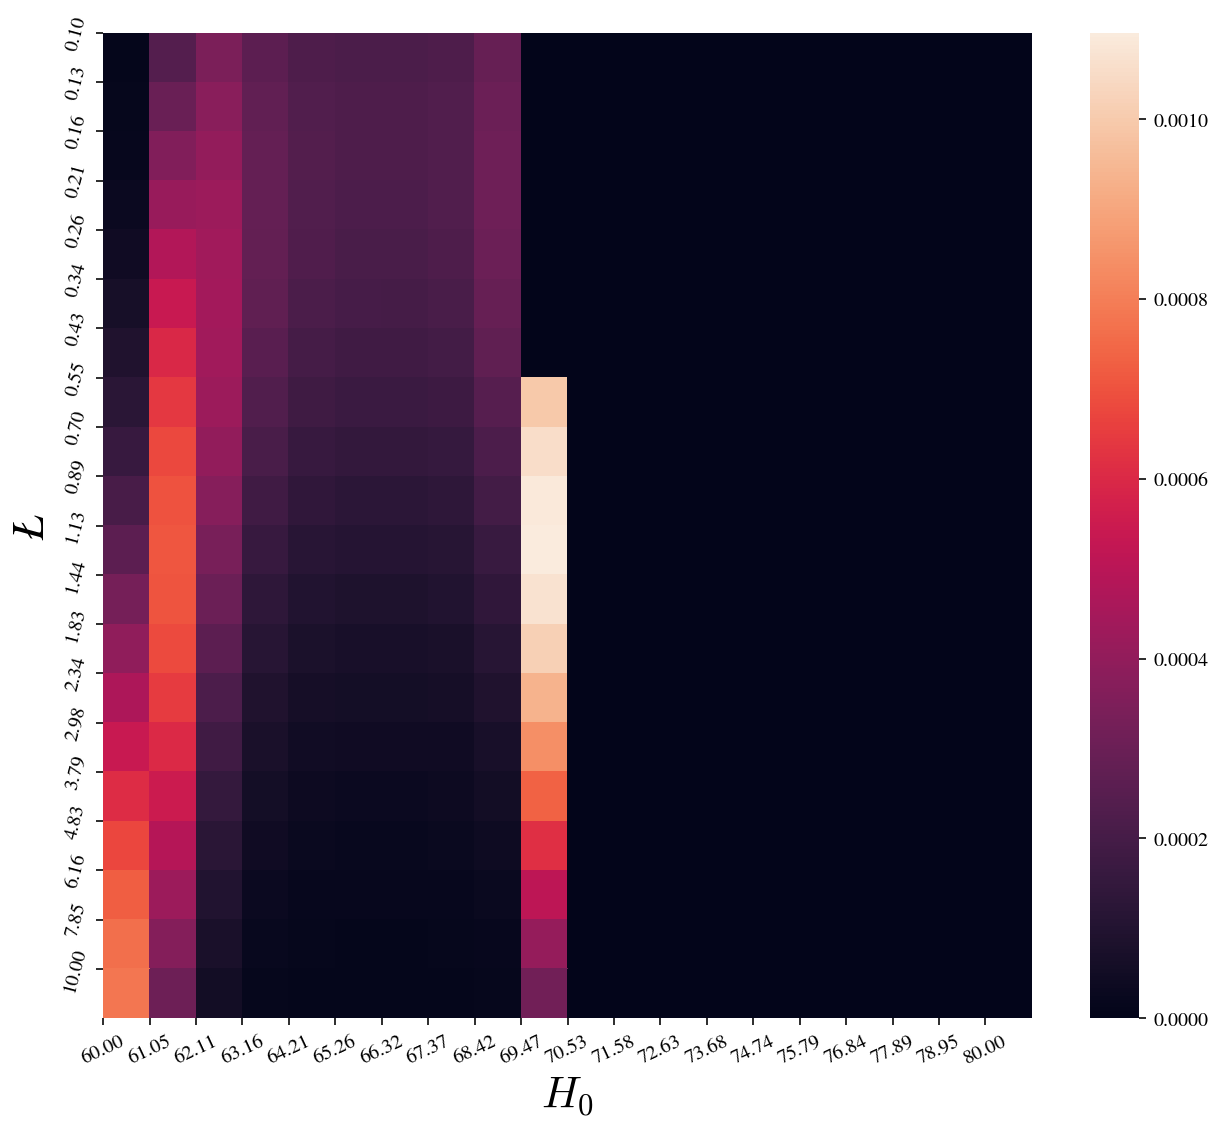

In [11]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

print(masked_data_with_aou_CC[10,9,0])
print(masked_data_with_aou_CC[10,0,0])
print(aux[10,9,0])
print(aux[10,0,0])
print(p3d[10,9,0])
print(p3d[10,0,0])

fig, ax = plt.subplots(figsize=(10, 8))
# Plot heatmaps without colorbars
sns.heatmap(p3d[:,:,0])


ax.set_xlabel(r'$H_0$', fontsize=22)
ax.set_ylabel(r'$\L$', fontsize=22)
ax.set_xticks(np.arange(len(H0_values)))
ax.set_yticks(np.arange(len(L_bar_values)))
ax.set_xticklabels([f'{tick:.2f}' for tick in H0_values[::-1]],rotation = 25)
ax.set_yticklabels([f'{tick:.2f}' for tick in L_bar_values],rotation = 75)
ax.label_outer()

fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


fig.savefig(os.path.join(path_figures, 'heat_map_aou_PG_r={0}_s={1}_beta=1.png'.format(r,s)))
fig.savefig(os.path.join(path_figures, 'heat_map_aou_PG_r={0}_s={1}_beta=1.pdf'.format(r,s)))
plt.show()

[[[3.39796841e-46 9.05164705e-41 1.03303989e-35 ... 5.02000707e-04
   7.38232472e-05 4.65118023e-06]
  [4.29155923e-43 7.12379715e-38 5.06627998e-33 ... 2.04220256e-04
   1.87143950e-05 7.34740494e-07]
  [7.84066045e-42 1.06468609e-36 6.19400740e-32 ... 1.22735114e-04
   9.20064561e-06 2.95494216e-07]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.49124826e-45 1.00893978e-39 9.71056800e-35 ... 3.66168083e-04
   4.54108059e-05 2.41278787e-06]
  [5.64329681e-42 7.85190370e-37 4.68056461e-32 ... 1.33626455e-04
   1.02639626e-05 3.37768297e-07]
  [1.04238638e-40 1.18204151e-35 5.74272390e-31 ... 7.62326598e-05
   4.77227669e-06 1.27994517e-07]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000

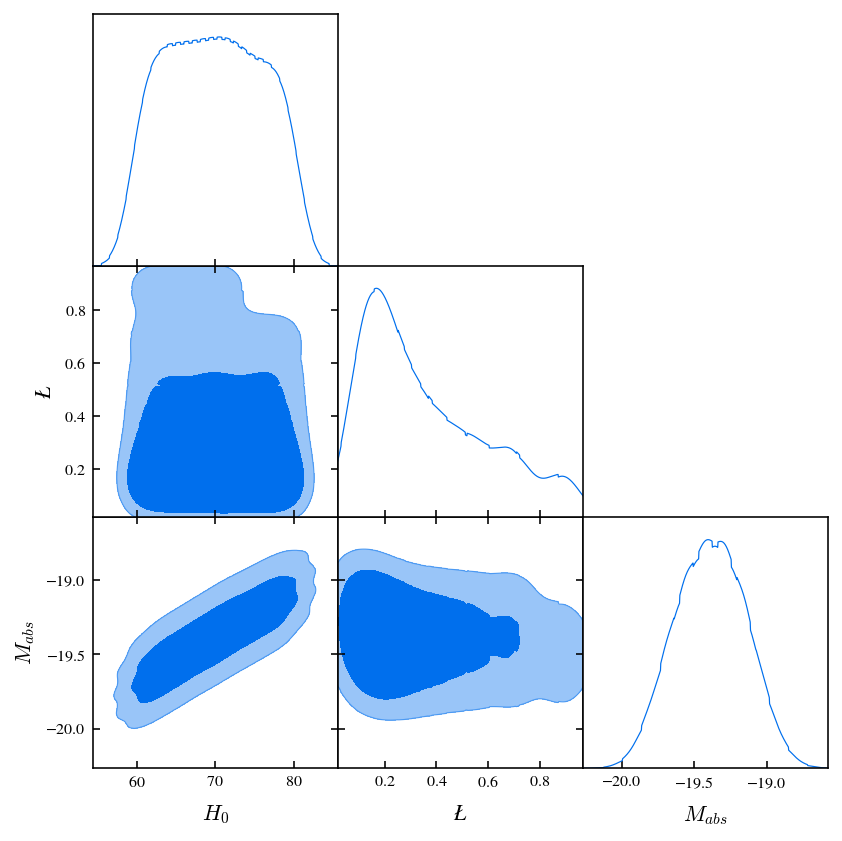

In [12]:
import getdist
import getdist.plots as gdplt
%matplotlib inline

x_vals = H0_values 
y_vals = L_bar_values 
z_vals = Mabs_values

aux = masked_data_with_aou_PPS.copy()/np.nanmin(masked_data_with_aou_PPS)
aux[np.isnan(masked_data_with_aou_PPS)] = np.inf

p3d = np.exp(-aux/2)

# Normalize the distribution
p3d /= np.sum(p3d)
print(p3d)
print(p3d.shape)
# Convert 3D posterior into samples
flattened_probs = p3d.flatten()
grid_points = np.array(np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')).reshape(3, -1).T

# Sample points from the distribution
num_samples = int(1e5)  # Number of samples you want
sample_indices = np.random.choice(len(flattened_probs), size=num_samples, p=flattened_probs)
samples = grid_points[sample_indices]
samples_PPS = samples.copy()

# Convert to GetDist format
gd_samples = getdist.mcsamples.MCSamples(samples=samples, names=['x', 'y', 'z'],
                                         labels=[r'H_0', r'\L', r'M_{abs}'],
                                         settings={'mult_bias_correction_order':0,
                                                   'smooth_scale_2D':0.3,
                                                   'smooth_scale_1D':0.3}
                                         )

# Plot using GetDist
g = gdplt.get_subplot_plotter()
g.triangle_plot([gd_samples], filled=True)
g.export(path_data+'triangle_gila_plot_PPS_{0}_r={1}_s={2}.pdf'.format(model, r, s))
plt.show()

# Confidence intervals 

In [13]:
print('PG model')
print('Exponents: r = {0}, s = {1}'.format(r,s))
print(r'M abs: {0:3f} \pm {1:3f}'.format(np.mean(samples_CC[:,2]), np.std(samples_CC[:,2])))
print(r'H0: {0:3f} \pm {1:3f}'.format(np.mean(samples_CC[:,0]), np.std(samples_CC[:,0])))
print(r'$\L$: {0:3f} \pm {1:3f}'.format(np.mean(samples_CC[:,1]), np.std(samples_CC[:,1])))

print('\n')
print(r'M abs: {0:3f} \pm {1:3f}'.format(np.mean(samples_PPS[:,2]), np.std(samples_PPS[:,2])))
print(r'H0: {0:3f} \pm {1:3f}'.format(np.mean(samples_PPS[:,0]), np.std(samples_PPS[:,0])))
print(r'$\L$: {0:3f} \pm {1:3f}'.format(np.mean(samples_PPS[:,1]), np.std(samples_PPS[:,1])))


PG model
Exponents: r = 1, s = 3
M abs: -19.749929 \pm 0.758755
H0: 70.313148 \pm 5.537685
$\L$: 0.387132 \pm 0.307677


M abs: -19.385970 \pm 0.235182
H0: 69.864495 \pm 5.991731
$\L$: 0.358076 \pm 0.235169


# Tension between PPS and CC

In [14]:
mean_A = np.array([np.mean(samples_CC[:,0]), np.mean(samples_CC[:,1]), np.mean(samples_CC[:,2])])

cov_11 = np.cov(samples_CC[:,0], samples_CC[:,0])[0][1]
cov_22 = np.cov(samples_CC[:,1], samples_CC[:,1])[0][1]
cov_33 = np.cov(samples_CC[:,2], samples_CC[:,2])[0][1]
cov_12 = np.cov(samples_CC[:,0], samples_CC[:,1])[0][1]
cov_13 = np.cov(samples_CC[:,0], samples_CC[:,2])[0][1]
cov_23 = np.cov(samples_CC[:,1], samples_CC[:,2])[0][1]

cov_tot_A = np.array([[cov_11, cov_12, cov_13],
                      [cov_12, cov_22, cov_23],
                      [cov_13, cov_23, cov_33]])
print('Covariance matrix:')
print(cov_tot_A)

cov_11 = np.cov(samples_PPS[:,0], samples_PPS[:,0])[0][1]
cov_22 = np.cov(samples_PPS[:,1], samples_PPS[:,1])[0][1]
cov_33 = np.cov(samples_PPS[:,2], samples_PPS[:,2])[0][1]
cov_12 = np.cov(samples_PPS[:,0], samples_PPS[:,1])[0][1]
cov_13 = np.cov(samples_PPS[:,0], samples_PPS[:,2])[0][1]
cov_23 = np.cov(samples_PPS[:,1], samples_PPS[:,2])[0][1]

cov_tot_B = np.array([[cov_11, cov_12, cov_13],
                      [cov_12, cov_22, cov_23],
                      [cov_13, cov_23, cov_33]])
print('Covariance matrix:')
print(cov_tot_B)

mean_B = np.array([np.mean(samples_PPS[:,0]), np.mean(samples_PPS[:,1]), np.mean(samples_PPS[:,2])])

delta_theta = mean_A - mean_B
cov_tot = cov_tot_A + cov_tot_B

Covariance matrix:
[[ 3.06659820e+01 -8.63051700e-02 -6.91323080e-04]
 [-8.63051700e-02  9.46650363e-02  5.05225734e-05]
 [-6.91323080e-04  5.05225734e-05  5.75709227e-01]]
Covariance matrix:
[[ 3.59011996e+01 -1.39000153e-01  1.09025305e+00]
 [-1.39000153e-01  5.53049540e-02 -8.30101364e-03]
 [ 1.09025305e+00 -8.30101364e-03  5.53111217e-02]]


In [15]:
from scipy.stats import chi2
from scipy.special import erfinv

# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)
alpha = np.dot(delta_theta.T,np.dot(A_matrix, delta_theta)) \

print(r'$Q_DM$: {}'.format(alpha))

PTE = chi2.sf(alpha, 3)
print('PTE: {}'.format(PTE))

n_sigma = from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

$Q_DM$: 0.23304412070483402
PTE: 0.9720863934931352
n_sigma: 0.0349917
